## GRAD CAM ++

The code implements GRAD CAM++, the aim of the code is to test the algorithm on multiple CNN models. This code can take only a single image as input. 

In [1]:
## Import the necessary Libraries 


import tensorflow.compat.v1 as tf
import numpy as np
import keras
from keras import backend as K
from skimage import io
from skimage.transform import resize
from scipy.misc import imread, imresize
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.models import Model
from matplotlib import pyplot as plt

tf.compat.v1.disable_eager_execution()
import cv2

2021-12-07 06:38:02.527006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:38:02.527044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
## Uncomment the model that you want the code to work with 


# InputModel = tf.keras.applications.VGG16(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

InputModel = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
#     **kwargs
)


# InputModel = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )


# InputModel = tf.keras.applications.ResNet101(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )

Instructions for updating:
Colocations handled automatically by placer.


2021-12-07 06:38:04.276560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:38:04.276591: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-07 06:38:04.276613: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sudarshan): /proc/driver/nvidia/version does not exist
2021-12-07 06:38:07.749204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable t

In [3]:
## Display the various layers in the input model note down the name of the final convolutional layer 

InputModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [4]:
## generating explanation maps for the multiple dogs image 
ImgPath = 'multiple_dogs.jpg'

img = imread(ImgPath, mode='RGB')
img = imresize(img, (224, 224))

x = np.expand_dims(img, axis=0) # [224,224 , 3 ] -> [1 , 224,224 , 3 ]
x = x[:,:,:,::-1]

/tmp/ipykernel_73548/3058314278.py:4: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(ImgPath, mode='RGB')
/tmp/ipykernel_73548/3058314278.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  img = imresize(img, (224, 224))


In [5]:
sess = tf.Session()
prob = InputModel.predict(x) ## Generate the Predictions Vector 

input_img =  x


/home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [6]:
predicted_class = np.argmax(prob) ## Get the predicted Class i.e. the class with the maximum prediction accuracy 


## According to the choosen model set appropriate name for the layer 
## EfficientNet = 'top_activation'
## VGG = 'block5_pool'
## Resnet50/101 = 'conv5_block3_out'

layer_name = 'top_activation' 

NumClasses = np.shape(prob)[1]


In [7]:
#  construct a loss function that returns the value at the output layer responsible for the given prediction  

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [8]:

def target_category_loss_output_shape(input_shape):
    return input_shape

In [9]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [10]:
    
## A loss function to initiate back propagation, it is a product of the input value for predicted class and the one-hot encoded
## vector
target_layer = lambda x: target_category_loss(x, predicted_class, NumClasses)
x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(InputModel.output)

model = Model(inputs=InputModel.input, outputs=x)

In [11]:
loss = K.sum(model.output) # alternatively can be replaced with K.sum( tf.exp( model.output))

for l in model.layers:
    
    if( l.name == layer_name ):
        conv_output = l.output

In [12]:
## Determine gradeints  The below code implements 
#Eq. 19 in the GRAD CAM++ paper (https://arxiv.org/pdf/1710.11063.pdf)

grads = normalize(K.gradients(loss, conv_output)[0])
gradient_function = K.function([model.layers[0].input], [conv_output, grads])
activation_maps, grads_val = gradient_function([input_img])
activation_maps = activation_maps[ 0 , :]
grads_val = grads_val[0 , :]

grads2 =  grads_val*grads_val
grads3  = grads_val*grads_val*grads_val



alpha_numerator = grads2
alpha_demonimator1 = 2*grads2


scale = np.sum( activation_maps , axis=( 0 , 1) )

alpha_demonimator2  = scale*grads3
alpha_demonimator2 = np.where(alpha_demonimator2 != 0.0, alpha_demonimator2, np.ones(alpha_demonimator2.shape))

alpha_demonimator =  alpha_demonimator2 + alpha_demonimator1
alpha = alpha_numerator/alpha_demonimator

weights1 = np.maximum(grads_val , 0 )

alphas_threshold_relu = np.where(weights1, alpha, 0.0)
alpha_normalized = np.sum(np.sum(alphas_threshold_relu, axis=0),axis=0)

alpha_normalized = np.where(alpha_normalized != 0.0, alpha_normalized, np.ones(alpha_normalized.shape))
alpha /= alpha_normalized.reshape((1,1,activation_maps.shape[2]))

deep_linearization_weights = np.sum((weights1*alpha).reshape((-1,activation_maps.shape[2])),axis=0)

dim = np.shape(activation_maps)[0]
localization_result = np.ones( (dim, dim) , dtype =np.float32 )

for i in range( len(deep_linearization_weights)):
    localization_result += deep_linearization_weights[i]*activation_maps[: , : , i]






### Visulization and Evaluation Section 

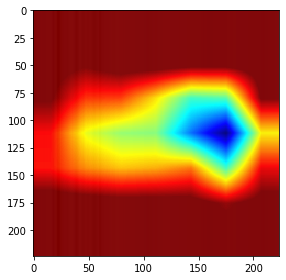

True

In [13]:
## Generation of HeatMaps

cam = cv2.resize(localization_result, (224, 224))
cam = np.maximum(cam, 0)
heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
image = img[0, :]
image -= np.min(image)
image = np.minimum(image, 255)
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
cam = 10*np.float32(cam) + np.float32(image)
cam = 255 * cam / np.max(cam)
cam = np.uint8(cam)

io.imshow(cam)
plt.show()
cam =  cv2.cvtColor(cam , cv2.COLOR_BGR2RGB ) 
cv2.imwrite("person_and_dogs_grad_cam++.png" ,cam  )

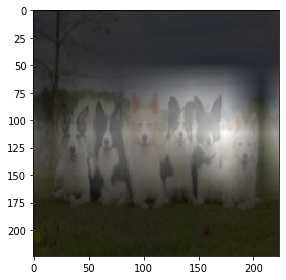

In [14]:
## Generation of Explanation Maps


localization_result = np.maximum (localization_result , 0 )
localization_result = localization_result / np.max(localization_result)
localization_result = resize(localization_result, (224,224))
cam3 = np.expand_dims(localization_result, axis=2)
cam3 = np.tile(cam3,[1,1,3])
img = img.astype(float)
img /= img.max()
new_img = img+4*cam3
new_img /= new_img.max()

io.imshow(new_img)
plt.show()

## Saving the Results 

In [15]:
CAMSavePath = 'Results/multiple_dogs_grad_Cam++.png'
ExpSavePath = 'Results/multiple_dogs_grad_Cam++Exp.png'

io.imsave(CAMSavePath , cam)
io.imsave(ExpSavePath , new_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
